In [152]:
from maply.geometry import Polygon
from maply.plot import Map
import geopandas as gpd
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')


import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), '..', 'src')))
from sp_geoprocessing import cluster, superparcels, utils

In [153]:
p1 = Polygon(origin=(0,0), size=(1,1), data={'id': 'A'})
p2 = Polygon(origin=(1,0), size=(1,1), data={'id': 'B'})
p3 = Polygon(origin=(0,1), size=(1,1), data={'id': 'A'})
p4 = Polygon(origin=(1,1), size=(1,1), data={'id': 'B'})

p5 = Polygon(origin=(4,0), size=(1,1), data={'id': 'A'})
p6 = Polygon(origin=(4,1), size=(1,1), data={'id': 'A'})
p7 = Polygon(origin=(5,0), size=(1,1), data={'id': 'A'})
p8 = Polygon(origin=(5,1), size=(1,1), data={'id': 'A'})

p9 = Polygon(origin=(4,3), size=(1,1), data={'id': 'A'})
p10 = Polygon(origin=(5,3), size=(1,1), data={'id': 'A'})

p_list = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10]

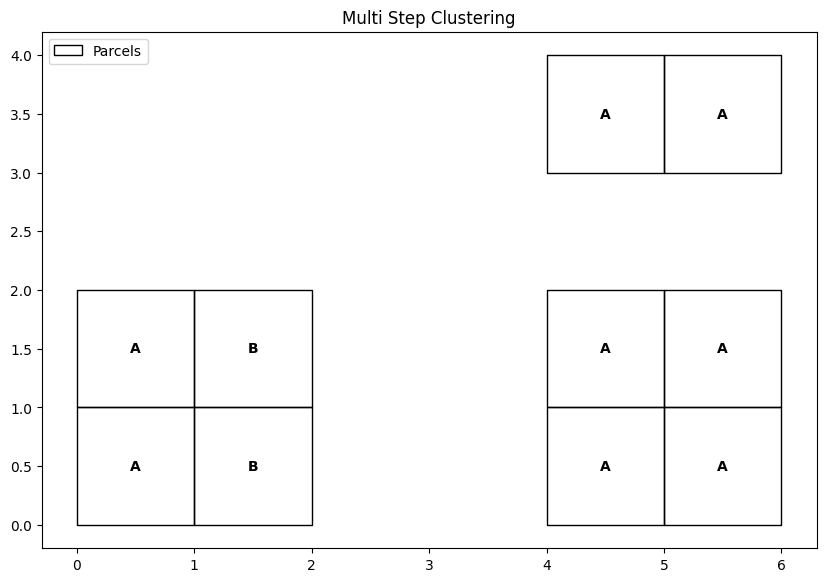

In [154]:
m = Map(title='Multi Step Clustering')
for p in p_list:
    m.add_shape(p,layer='Parcels', style={'facecolor': 'none'}, label='id')
m.plot()

In [155]:
candidate_parcels = gpd.GeoDataFrame()
for p in p_list:
    candidate_parcels = pd.concat([candidate_parcels, p.to_gdf()], ignore_index=True)
candidate_parcels = candidate_parcels.reset_index(drop=True)
candidate_parcels

,id,geometry
0,A,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))"
1,B,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))"
2,A,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))"
3,B,"POLYGON ((1 1, 2 1, 2 2, 1 2, 1 1))"
4,A,"POLYGON ((4 0, 5 0, 5 1, 4 1, 4 0))"
5,A,"POLYGON ((4 1, 5 1, 5 2, 4 2, 4 1))"
6,A,"POLYGON ((5 0, 6 0, 6 1, 5 1, 5 0))"
7,A,"POLYGON ((5 1, 6 1, 6 2, 5 2, 5 1))"
8,A,"POLYGON ((4 3, 5 3, 5 4, 4 4, 4 3))"
9,A,"POLYGON ((5 3, 6 3, 6 4, 5 4, 5 3))"


In [156]:
# multi step eps
eps_list = [6, 3, 2, 1]
color_list = ['red', 'blue', 'green', 'yellow']
AREA_RATIO_THRESHOLD = 0.7
for owner in candidate_parcels['id'].unique():
    print(f'Owner: {owner}')
    owner_parcels = candidate_parcels[candidate_parcels['id'] == owner]
    
    for eps in eps_list:
        print(f'Eps: {eps}')
        clusters = cluster.build_owner_clusters(
            owner_parcels, 
            min_samples=3,
            eps=eps
        ) 
        
        if len(clusters) == 0: # EMPTY: NO CLUSTERS
            continue

        owner_parcels['cluster'] = clusters # clustert ID
        
        owner_parcels['cluster_area'] = owner_parcels['geometry'].area
        owner_parcels['cluster_area'] = owner_parcels['cluster_area'].astype(int)

        counts = owner_parcels['cluster'].value_counts() # pd.series of cluster counts
        
        outlier_ids, clean_counts = utils.segregate_outliers(counts, -1)

        cluster_filter = utils.remove_from_df(
            df=owner_parcels, 
            list_of_ids=outlier_ids, 
            field='cluster'
        )

        if len(cluster_filter) > 0:
            # calcualte total area
            total_area = cluster_filter.groupby('cluster')['cluster_area'].sum()

            # add attributes
            cluster_filter = utils.add_attributes(
                cluster_filter,
                pcount=cluster_filter['cluster'].map(clean_counts),
                p_area=cluster_filter['cluster'].map(total_area),
            )
            cluster_filter = cluster_filter[['id', 'cluster', 'pcount', 'p_area', 'geometry']]
            
        sp = superparcels.build_superparcels(
            cluster_filter,
            buffer=eps,
            dissolve_by='cluster'
        )
        sp_color = color_list[eps_list.index(eps)]
        sp['sp_area'] = sp['geometry'].area
        sp['area_ratio'] = np.round(sp['p_area'] / sp['sp_area'],1)
        sp['type'] = f'sp_{eps}'
        
        # add to map
        m.add_gdf(
            sp, 
            layer=sp['type'].values[0],
            style={'facecolor': 'none', 'edgecolor':sp_color}, 
            
        )

        owner_area_ratio = sp['area_ratio'].values[0]
        print(f'Owner Area ratio: {owner_area_ratio}')
        if owner_area_ratio >= AREA_RATIO_THRESHOLD:
            break  # success, move to next owner

    break # Only test owner A
        
 

Owner: A
Eps: 6
Owner Area ratio: 0.4
Eps: 3
Owner Area ratio: 0.5
Eps: 2
Owner Area ratio: 0.8


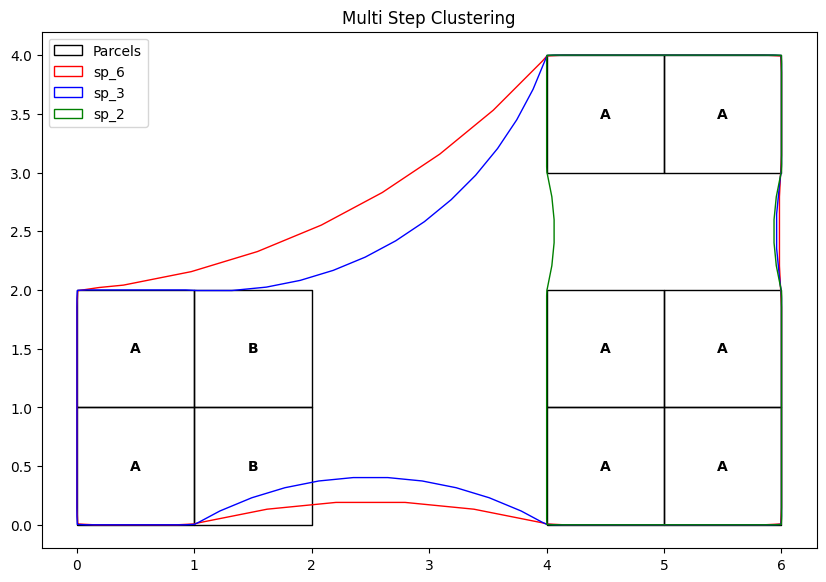

In [157]:
m.plot()